In [1]:
import os,librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd
import seaborn as sns

In [2]:
seed=15
n_MFCC=13
column_names= ['MFCC_'+str(i) for i in range(1,n_MFCC+1)]

In [3]:
DATA_PATH="./Vowel_Data/Vowel/"

In [4]:
def get_mfcc(file_path):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    mfcc_df=pd.DataFrame(mfcc.T,columns=column_names) #convert array to pandas df
    return mfcc_df

def get_all_mfcc(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    all_mfcc=pd.DataFrame() #empty dataframe to store all_mfccs
    
    for label_index,label in enumerate(labels):
        folder_mfcc=pd.DataFrame() #empty dataframe to store mfcc of indivuals vowels/words i.e. folders

        speech_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(speech_files,"Reading Speech of label -'{}'".format(label)):
            #print(file)
            individual_mfcc=get_mfcc(file_path=file)
            folder_mfcc=folder_mfcc.append(individual_mfcc,ignore_index=True)
        
        folder_mfcc['label']=label_index  #new columns for encoding label
        
        all_mfcc=all_mfcc.append(folder_mfcc,ignore_index=True)
        
    return all_mfcc

def get_train_test(split_ratio=0.8,random_state=42):
    all_mfccs=get_all_mfcc()
    
    y=all_mfccs['label'].values
    
    only_mfcc=all_mfccs.drop(labels=['label'],axis=1)
    standard_mfcc=(only_mfcc-only_mfcc.mean())/only_mfcc.std()
    X=standard_mfcc.values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [5]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Speech of label -'vowel7': 100%|██████████| 40/40 [00:00<00:00, 101.74it/s]


In [6]:
np.random.seed(seed)
model_v=Sequential()
#model_v.add(Dense(128, activation='relu', input_shape=(6,)))
#model_v.add(Dense(64, activation='relu'))
model_v.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

In [7]:
model_v.compile(
    #optimizer=opt.SGD(learning_rate=0.005,momentum=0.9),
    optimizer=opt.Adam(learning_rate=0.005),
    #loss=losses.CategoricalCrossentropy(),
    loss='categorical_crossentropy',
    #metrics=['AUC'],
    #metrics=['accuracy']#,
    metrics=[['accuracy','AUC']]
)

In [8]:
history_v=model_v.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
1/1 [==============================] - 0s 351ms/step - loss: 1.9895 - accuracy: 0.1545 - auc: 0.5531 - val_loss: 1.9014 - val_accuracy: 0.2063 - val_auc: 0.6090
Epoch 2/50
1/1 [==============================] - 0s 73ms/step - loss: 1.8899 - accuracy: 0.2061 - auc: 0.6174 - val_loss: 1.8091 - val_accuracy: 0.2616 - val_auc: 0.6714
Epoch 3/50
1/1 [==============================] - 0s 93ms/step - loss: 1.8000 - accuracy: 0.2696 - auc: 0.6779 - val_loss: 1.7261 - val_accuracy: 0.3068 - val_auc: 0.7257
Epoch 4/50
1/1 [==============================] - 0s 95ms/step - loss: 1.7189 - accuracy: 0.3168 - auc: 0.7301 - val_loss: 1.6516 - val_accuracy: 0.3500 - val_auc: 0.7698
Epoch 5/50
1/1 [==============================] - 0s 83ms/step - loss: 1.6460 - accuracy: 0.3622 - auc: 0.7727 - val_loss: 1.5844 - val_accuracy: 0.3905 - val_auc: 0.8040
Epoch 6/50
1/1 [==============================] - 0s 72ms/step 

In [9]:
history_dict=history_v.history

loss_v=history_dict['loss']
val_loss_v=history_dict['val_loss']

epochs=range(1,len(loss_v)+1)

acc_v=history_dict['accuracy']
val_acc_v=history_dict['val_accuracy']

auc_v=history_dict['auc']
val_auc_v=history_dict['val_auc']

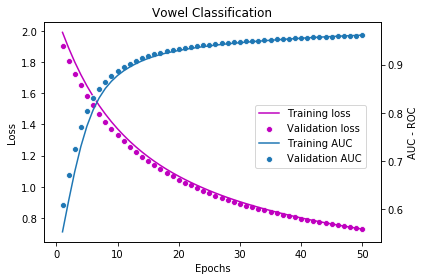

In [10]:
#plt.figure(figsize=(10,4))
ax=sns.lineplot(epochs,loss_v,label='Training loss',legend=False,color='m')
ax=sns.scatterplot(epochs,val_loss_v,label='Validation loss',legend=False,color='m')

ax2=ax.twinx()
ax2=sns.lineplot(epochs,auc_v,label='Training AUC',legend=False)
ax2=sns.scatterplot(epochs,val_auc_v,label='Validation AUC',legend=False)

ax.set_title('Vowel Classification')
ax.set(xlabel='Epochs', ylabel='Loss')
ax2.set(ylabel='AUC - ROC')

ax.figure.legend(loc=(0.6,0.4))
plt.tight_layout()
#plt.savefig('./New_without_CNN/loss_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

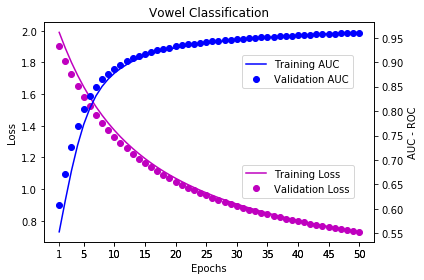

In [84]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_v,'m', label='Training Loss')
ln2=ax.plot(epochs,val_loss_v,'mo', label='Validation Loss')

ax2=ax.twinx()
ln3=ax2.plot(epochs,auc_v,'b', label='Training AUC')
ln3=ax2.plot(epochs,val_auc_v,'bo', label='Validation AUC')

ax.set_title('Vowel Classification')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax2.set_ylabel('AUC - ROC')

plt.xticks(ticks)
ax.legend(loc=(0.6,0.2))
ax2.legend(loc=(0.6,0.7))
#fig.legend(loc=(0.6,0.4))
plt.tight_layout()
#plt.savefig('./New_without_CNN/loss_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [41]:
ticks=[1]
ticks2=[i for i in range(5,len(loss_v)+1,5)]

In [45]:
ticks.extend(ticks2)

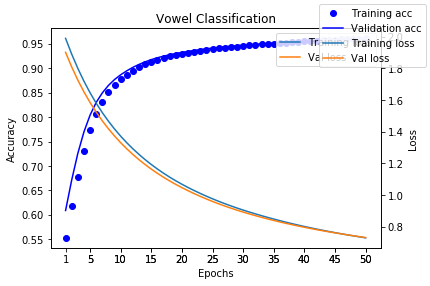

In [71]:
#plt.figure(figsize=(10,4))
fig, ax=plt.subplots()
ax.plot(epochs,auc_v,'bo',label='Training acc')
ax.plot(epochs,val_auc_v,'b',label='Validation acc')
ax2=ax.twinx()
ax2.plot(epochs,loss_v,label='Training loss')
ax2.plot(epochs,val_loss_v,label='Val loss')
plt.xticks(ticks)
#plt.xticks(epochs,rotation=90)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Vowel Classification')
ax2.set_ylabel('Loss')
fig.legend()
ax2.legend()
plt.tight_layout()
#plt.savefig('./New_without_CNN/accuracy_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

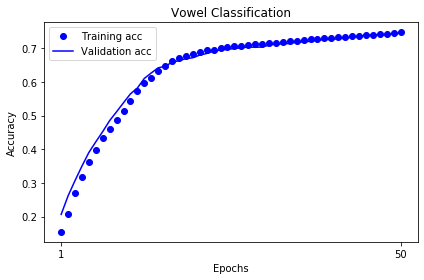

In [67]:
#plt.figure(figsize=(10,4))
plt.plot(epochs,acc_v,'bo',label='Training acc')
plt.plot(epochs,val_acc_v,'b',label='Validation acc')
plt.xticks([1, 50])
#plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Vowel Classification')
plt.legend()
plt.tight_layout()
#plt.savefig('./New_without_CNN/accuracy_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

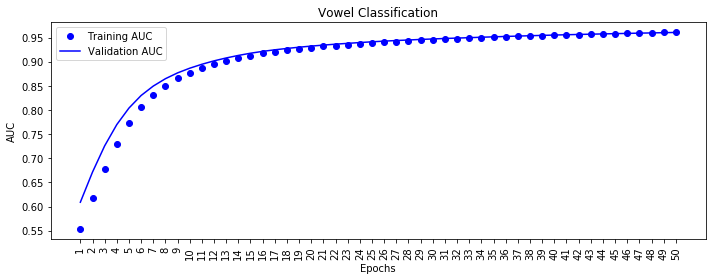

In [68]:
plt.figure(figsize=(10,4))
plt.plot(epochs,auc_v,'bo',label='Training AUC')
plt.plot(epochs,val_auc_v,'b',label='Validation AUC')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Vowel Classification')
plt.legend()
plt.tight_layout()
#plt.savefig('./New_without_CNN/AUC_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [85]:
DATA_PATH="./Word_Data/Word/"

In [86]:
def get_mfcc(file_path):
    wave, sr= librosa.load(file_path, mono=True, sr=None)
    mfcc=librosa.feature.mfcc(wave,sr=sr,n_mfcc=n_MFCC)
    mfcc_df=pd.DataFrame(mfcc.T,columns=column_names) #convert array to pandas df
    return mfcc_df

def get_all_mfcc(path=DATA_PATH):
    labels=sorted(os.listdir(path))
    all_mfcc=pd.DataFrame() #empty dataframe to store all_mfccs
    
    for label_index,label in enumerate(labels):
        folder_mfcc=pd.DataFrame() #empty dataframe to store mfcc of indivuals vowels/words i.e. folders

        speech_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(speech_files,"Reading Speech of label -'{}'".format(label)):
            #print(file)
            individual_mfcc=get_mfcc(file_path=file)
            folder_mfcc=folder_mfcc.append(individual_mfcc,ignore_index=True)
        
        folder_mfcc['label']=label_index  #new columns for encoding label
        
        all_mfcc=all_mfcc.append(folder_mfcc,ignore_index=True)
        
    return all_mfcc

def get_train_test(split_ratio=0.8,random_state=42):
    all_mfccs=get_all_mfcc()
    
    y=all_mfccs['label'].values
    
    only_mfcc=all_mfccs.drop(labels=['label'],axis=1)
    standard_mfcc=(only_mfcc-only_mfcc.mean())/only_mfcc.std()
    X=standard_mfcc.values

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [87]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Speech of label -'Word7': 100%|██████████| 40/40 [00:00<00:00, 111.37it/s]


In [88]:
np.random.seed(seed)
model_w=Sequential()
#model_w.add(Dense(128, activation='tanh', input_shape=(6,)))
#model_w.add(Dense(64, activation='tanh'))
model_w.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

In [89]:
model_w.compile(
    #optimizer=opt.SGD(learning_rate=0.005,momentum=0.9),
    optimizer=opt.Adam(learning_rate=0.005),
    #loss=losses.CategoricalCrossentropy(),
    loss='categorical_crossentropy',
    #metrics=['AUC'],
    #metrics=['accuracy']#,
    metrics=[['accuracy','AUC']]
)

In [90]:
history_w=model_w.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 0s 321ms/step - loss: 2.1134 - accuracy: 0.1599 - auc: 0.4858 - val_loss: 2.0089 - val_accuracy: 0.1852 - val_auc: 0.5362
Epoch 2/50
1/1 [==============================] - 0s 101ms/step - loss: 2.0249 - accuracy: 0.1800 - auc: 0.5265 - val_loss: 1.9282 - val_accuracy: 0.2221 - val_auc: 0.5882
Epoch 3/50
1/1 [==============================] - 0s 102ms/step - loss: 1.9445 - accuracy: 0.2090 - auc: 0.5768 - val_loss: 1.8565 - val_accuracy: 0.2626 - val_auc: 0.6405
Epoch 4/50
1/1 [==============================] - 0s 93ms/step - loss: 1.8731 - accuracy: 0.2496 - auc: 0.6281 - val_loss: 1.7946 - val_accuracy: 0.2959 - val_auc: 0.6827
Epoch 5/50
1/1 [==============================] - 0s 93ms/step - loss: 1.8113 - accuracy: 0.2813 - auc: 0.6706 - val_loss: 1.7423 - val_accuracy: 0.3164 - val_auc: 0.7141
Epoch 6/50
1/1 [==============================] - 0s 88ms/step - loss: 1.7591 - accuracy: 0.2961 - auc: 0.7021 - val_loss: 1.6994 - val_accura

Epoch 49/50
1/1 [==============================] - 0s 77ms/step - loss: 1.2896 - accuracy: 0.5075 - auc: 0.8575 - val_loss: 1.2901 - val_accuracy: 0.4992 - val_auc: 0.8569
Epoch 50/50
1/1 [==============================] - 0s 80ms/step - loss: 1.2859 - accuracy: 0.5098 - auc: 0.8584 - val_loss: 1.2866 - val_accuracy: 0.5008 - val_auc: 0.8578


In [91]:
history_dict=history_w.history
loss_w=history_dict['loss']
val_loss_w=history_dict['val_loss']

acc_w=history_dict['accuracy']
val_acc_w=history_dict['val_accuracy']

auc_w=history_dict['auc']
val_auc_w=history_dict['val_auc']

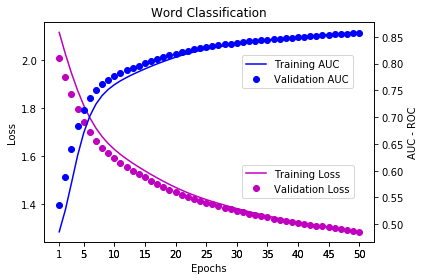

In [92]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_w,'m', label='Training Loss')
ln2=ax.plot(epochs,val_loss_w,'mo', label='Validation Loss')

ax2=ax.twinx()
ln3=ax2.plot(epochs,auc_w,'b', label='Training AUC')
ln3=ax2.plot(epochs,val_auc_w,'bo', label='Validation AUC')

ax.set_title('Word Classification')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax2.set_ylabel('AUC - ROC')

plt.xticks(ticks)
ax.legend(loc=(0.6,0.2))
ax2.legend(loc=(0.6,0.7))
#fig.legend(loc=(0.6,0.4))
plt.tight_layout()
#plt.savefig('./New_without_CNN/loss_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

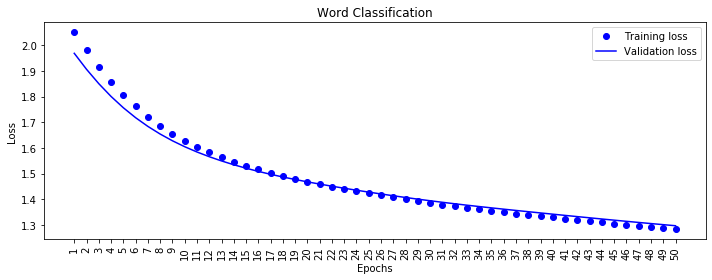

In [21]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_w,'bo',label='Training loss')
plt.plot(epochs,val_loss_w,'b',label='Validation loss')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Word Classification')
plt.legend()
plt.tight_layout()
#plt.savefig('./New_without_CNN/loss_word_'+save_specifier+'.pdf',format='pdf', dpi=600)

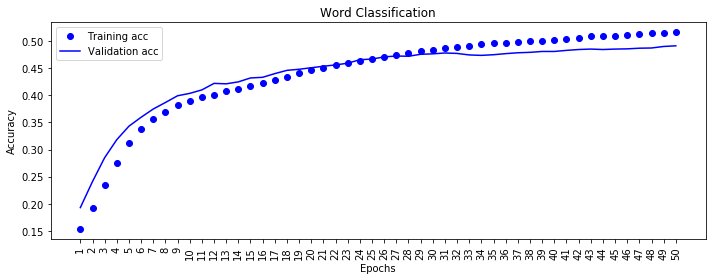

In [22]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_w,'bo',label='Training acc')
plt.plot(epochs,val_acc_w,'b',label='Validation acc')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Word Classification')
plt.legend()
plt.tight_layout()
#plt.savefig('./New_without_CNN/accuracy_word_'+save_specifier+'.pdf',format='pdf', dpi=600)

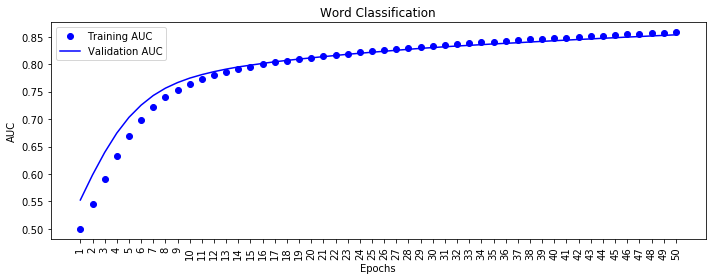

In [23]:
plt.figure(figsize=(10,4))
plt.plot(epochs,auc_w,'bo',label='Training AUC')
plt.plot(epochs,val_auc_w,'b',label='Validation AUC')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Word Classification')
plt.legend()
plt.tight_layout()
#plt.savefig('./New_without_CNN/AUC_word_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [24]:
#COMPARE

In [25]:
save_specifier='standard_mfcc_32_16_tanh_softmax_adam_0.005_batchfull'

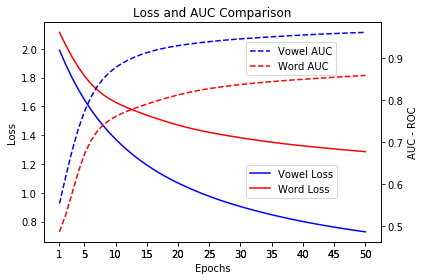

In [95]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_v,'b', label='Vowel Loss')
ln2=ax.plot(epochs,loss_w,'r', label='Word Loss')

ax2=ax.twinx()
ln3=ax2.plot(epochs,auc_v,'b--', label='Vowel AUC')
ln3=ax2.plot(epochs,auc_w,'r--', label='Word AUC')

ax.set_title('Loss and AUC Comparison')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax2.set_ylabel('AUC - ROC')

plt.xticks(ticks)
ax.legend(loc=(0.6,0.2))
ax2.legend(loc=(0.6,0.76))
#fig.legend(loc=(0.6,0.4))
plt.tight_layout()
#plt.savefig('./New_without_CNN/loss_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

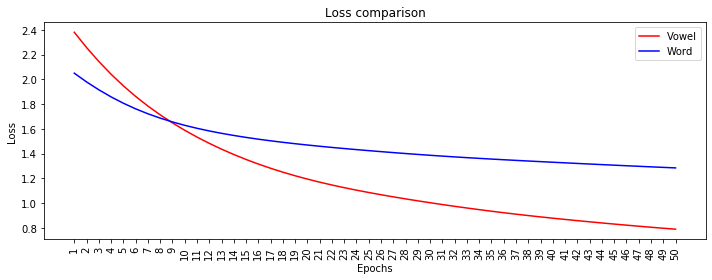

In [26]:
#sns.reset()
#sns.reset_orig()
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'r',label='Vowel')
plt.plot(epochs,loss_w,'b',label='Word')
plt.title('Loss comparison')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.savefig('./New_without_CNN/loss_compare_'+save_specifier+'.pdf',format='pdf',dpi=600)

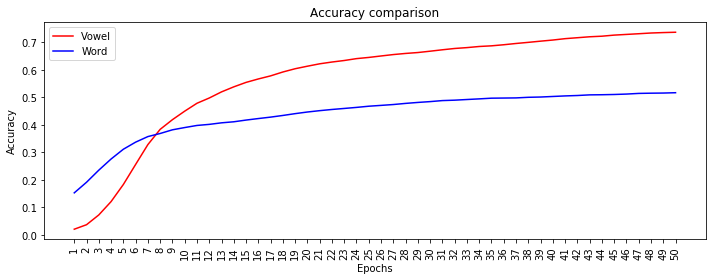

In [27]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_v,'r',label='Vowel')
plt.plot(epochs,acc_w,'b',label='Word')
plt.title('Accuracy comparison')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
#plt.savefig('./New_without_CNN/accuracy_compare_'+save_specifier+'.pdf',format='pdf',dpi=600)

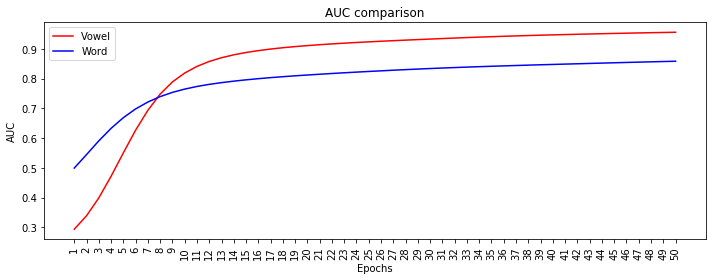

In [28]:
plt.figure(figsize=(10,4))
plt.plot(epochs,auc_v,'r',label='Vowel')
plt.plot(epochs,auc_w,'b',label='Word')
plt.title('AUC comparison')
plt.xticks(epochs,rotation=90)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
#plt.savefig('./New_without_CNN/AUC_compare_'+save_specifier+'.pdf',format='pdf',dpi=600)

In [44]:
all_compare_df=pd.DataFrame({'loss_v':loss_v,
                      'val_loss_v':val_loss_v,
                      'acc_v':acc_v,
                      'val_acc_v':val_acc_v,
                      'auc_v':auc_v,
                      'val_auc_v':val_auc_v,
                      'loss_w':loss_w,
                      'val_loss_w':val_loss_w,
                      'acc_w':acc_w,
                      'val_acc_w':val_acc_w,
                      'auc_w':auc_w,
                      'val_auc_w':val_auc_w
                     })

all_compare_df.to_csv('./New_without_CNN/all_compare_data_'+save_specifier+'.csv')

In [67]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.087982,1.079178,0.578892,0.576316,0.914252,0.914130,1.465496,1.461363,0.433841,0.435846,0.808475,0.810116
46,1.073246,1.063786,0.580471,0.586316,0.916134,0.916380,1.460930,1.456924,0.435345,0.437049,0.809607,0.811218
47,1.058198,1.051638,0.585735,0.577368,0.918239,0.917834,1.456578,1.452782,0.435445,0.443865,0.810850,0.812264
48,1.043170,1.040124,0.585867,0.578421,0.920454,0.919898,1.452407,1.448659,0.439755,0.447875,0.812117,0.813237
49,1.030735,1.028717,0.590604,0.581053,0.922445,0.921268,1.448298,1.444540,0.444968,0.446672,0.813397,0.814203


In [45]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,0.747012,0.753977,0.741413,0.727895,0.960994,0.959738,1.281573,1.291772,0.509824,0.504010,0.859364,0.856465
46,0.740706,0.747679,0.742203,0.727895,0.961514,0.960330,1.277932,1.287836,0.511628,0.503609,0.860304,0.857371
47,0.734629,0.741603,0.743387,0.728421,0.961970,0.960810,1.274361,1.283999,0.512831,0.503609,0.861195,0.858353
48,0.728761,0.735736,0.745493,0.731053,0.962445,0.961305,1.270858,1.280256,0.513031,0.506816,0.862042,0.859321
49,0.723083,0.730062,0.745756,0.734211,0.962883,0.961810,1.267420,1.276603,0.514635,0.510024,0.862903,0.860176
